<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 12/12/18.**

**Convolutional Neural Networks.**
---
In this notebook, I train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

In [73]:
### Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [0]:
### Import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import PIL 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

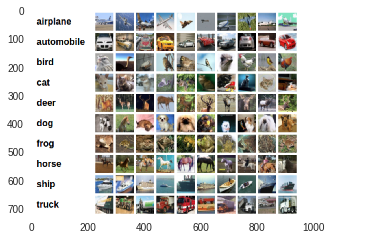

In [76]:
### CIFAR10 data image
cifar10 = mpimg.imread("/content/drive/My Drive/Images/cifar_data.png") 
plt.imshow(cifar10)
plt.grid(False)

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

**Since these are larger (32x32x3) images, it may prove useful to speed up my training time by using a GPU.** 

In [77]:
### Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

**Downloading may take a minute. I load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.**

In [78]:
### Number of subprocesses to use for data loading
num_workers = 0

### How many samples per batch to load
batch_size = 20

### Percentage of training set to use as validation
valid_size = 0.2

### Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

### Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

### Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

### Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [0]:
### Helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

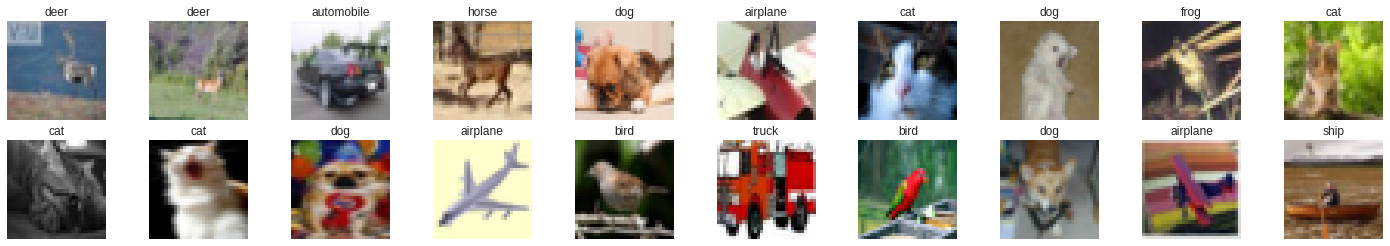

In [80]:
### Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

### Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
### Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

**Here, I look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.**

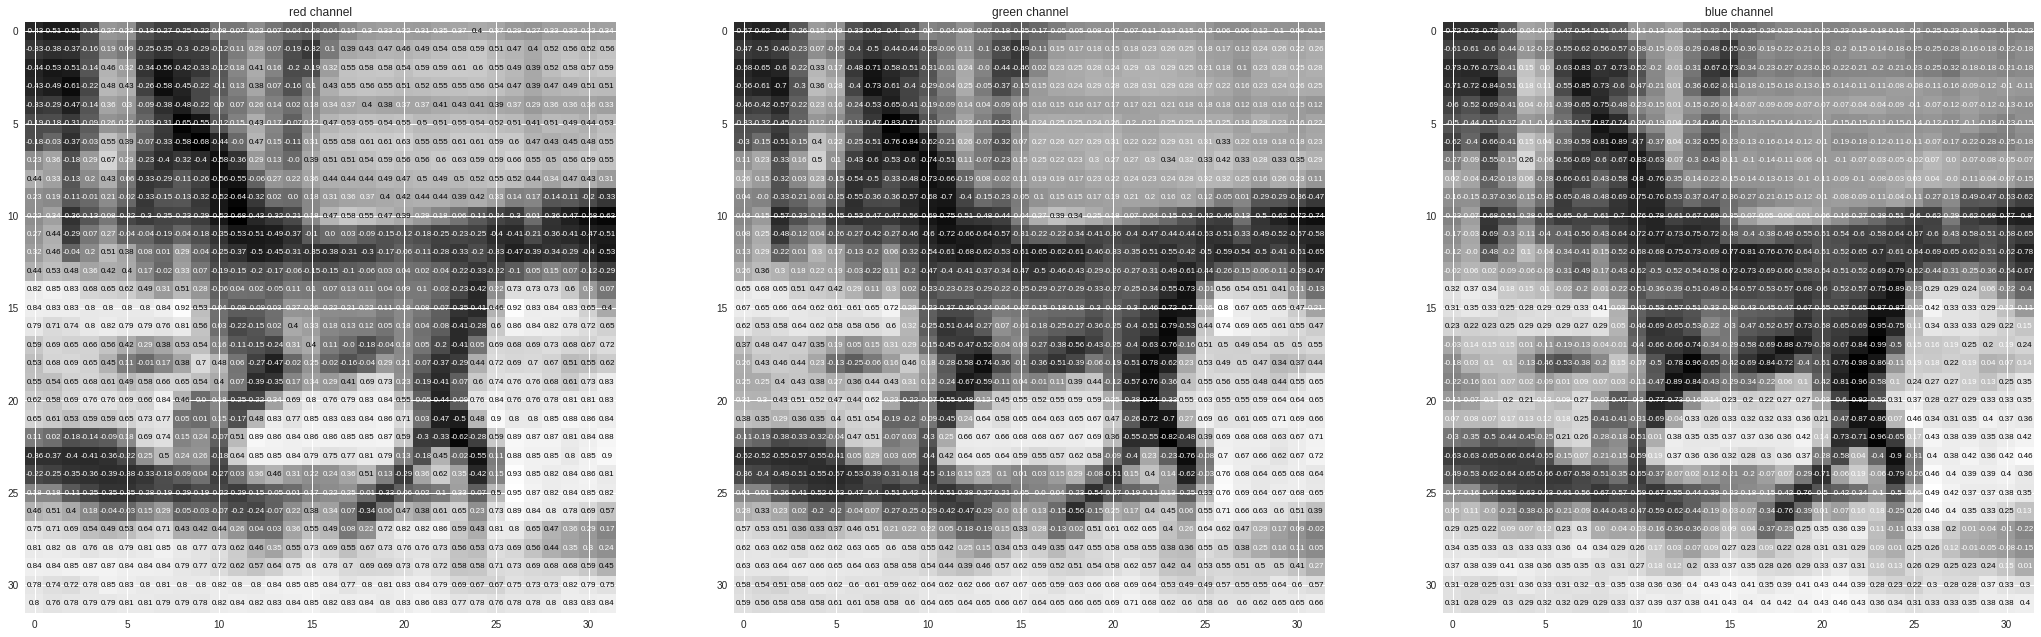

In [81]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

Now I will define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, I'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

The more convolutional layers I include, the more complex patterns in color and shape a model can detect. I will include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 



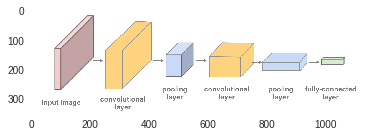

In [82]:
### A network with 2 convolutional layers is shown in the image below 
conv_2layer = mpimg.imread("/content/drive/My Drive/Images/2_layer_conv.png") 
plt.imshow(conv_2layer)
plt.grid(False)



In [83]:
### Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ### Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        ### Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        ### Linear layers
        self.fc1 = nn.Linear(64 * 4 * 4, 500) 
        self.fc2 = nn.Linear(500, 10) 
        
        ### Dropout layer
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        ### Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        ### Flatten image input 
        x = x.view(-1, 64 * 4 * 4)
        
        ### Add dropout layer
        x = self.dropout(x)
        
        ### Add 1st hidden layer
        x = F.relu(self.fc1(x)) 
        ### Add dropout layer
        x = self.dropout(x)
        ### Add 2nd hidden layer
        x = self.fc2(x)
        
        return x

### Create a complete CNN
model = Net()
print(model)

### Move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

**I will decide on loss and optimization functions that are best suited for this classification task.** 

In [0]:
### Specify loss function
criterion = nn.CrossEntropyLoss()

### Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

**Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.**

In [85]:
### Number of epochs to train the model
n_epochs = 2

### Store the minimum validation loss
valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    ### Keep track of the training and validation losses
    train_loss = 0.0
    valid_loss = 0.0
        
    ### Training loop
    model.train()
    for data, target in train_loader:
        ### Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        ### Clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        ### Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        ### Calculate the batch loss
        loss = criterion(output, target)
        
        ### Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        ### Perform a single optimization step (parameter update)
        optimizer.step()
        
        ### Update training loss
        train_loss += loss.item()*data.size(0)
        
    ### Validation loop
    model.eval()
    for data, target in valid_loader:
        #### Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        ### Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        ### Calculate the batch loss
        loss = criterion(output, target)
        
        ### Update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    ### Calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    ### Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    ### Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.708126 	Validation Loss: 0.387441
Validation loss decreased (inf --> 0.387441).  Saving model ...
Epoch: 2 	Training Loss: 1.408046 	Validation Loss: 0.312251
Validation loss decreased (0.387441 --> 0.312251).  Saving model ...


###  Load the Model with the Lowest Validation Loss

In [0]:
### Load the best model
model.load_state_dict(torch.load('model_cifar.pt'))

---
## Test the Trained Network

**Test my trained model on previously unseen data. **

In [87]:
### Track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

### Testing loop
model.eval()
### Iterate over test data
for data, target in test_loader:
    ### Move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    ### Forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    
    ### Calculate the batch loss
    loss = criterion(output, target)
    
    ### Update test loss 
    test_loss += loss.item()*data.size(0)
    
    ### Convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    ### Compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    ### Calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

### Average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.543454

Test Accuracy of airplane: 44% (445/1000)
Test Accuracy of automobile: 44% (443/1000)
Test Accuracy of  bird: 21% (212/1000)
Test Accuracy of   cat: 26% (264/1000)
Test Accuracy of  deer: 18% (181/1000)
Test Accuracy of   dog: 48% (483/1000)
Test Accuracy of  frog: 68% (683/1000)
Test Accuracy of horse: 43% (437/1000)
Test Accuracy of  ship: 48% (485/1000)
Test Accuracy of truck: 68% (683/1000)

Test Accuracy (Overall): 43% (4316/10000)


### Visualize Sample Test Results

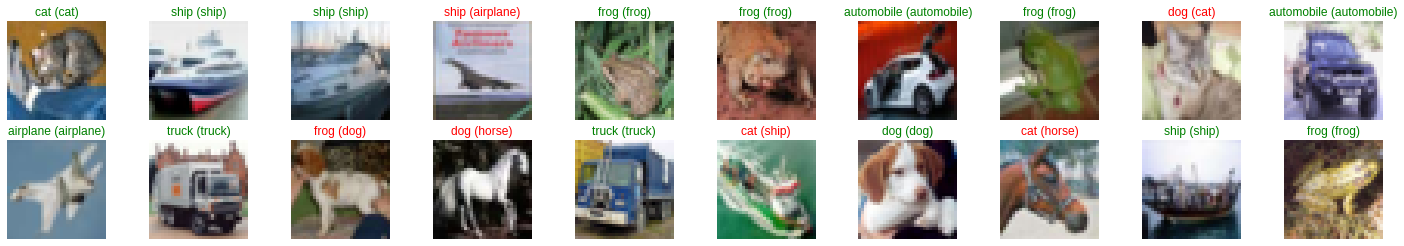

In [88]:
### Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

### Move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

### Get sample outputs
output = model(images)

### Convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

### Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))